In [2]:
# 1. Install dependencies
!pip install librosa tensorflow scikit-learn plotly streamlit



In [3]:
# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All libraries imported successfully!
Librosa upgraded successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Loading and processing RAVDESS dataset...
Found 1006 files in Audio_Song_Actors_*
Processing file 1/1006
Processing file 101/1006
Processing file 201/1006
Processing file 301/1006
Processing file 401/1006
Processing file 501/1006
Processing file 601/1006
Processing file 701/1006
Processing file 801/1006
Processing file 901/1006
Processing file 1001/1006
Found 1441 files in Audio_Speech_Actors_*
Processing file 1/1441
Processing file 101/1441
Processing file 201/1441
Processing file 301/1441
Processing file 401/1441
Processing file 501/1441
Processing file 601/1441
Processing file 701/1441
Processing file 801/1441
Processing file 901/1441
Processing file 1001/1441
Processing file 1101/1441
Processing file 1201/1441
Processing file 1301/1441
Processing file 14

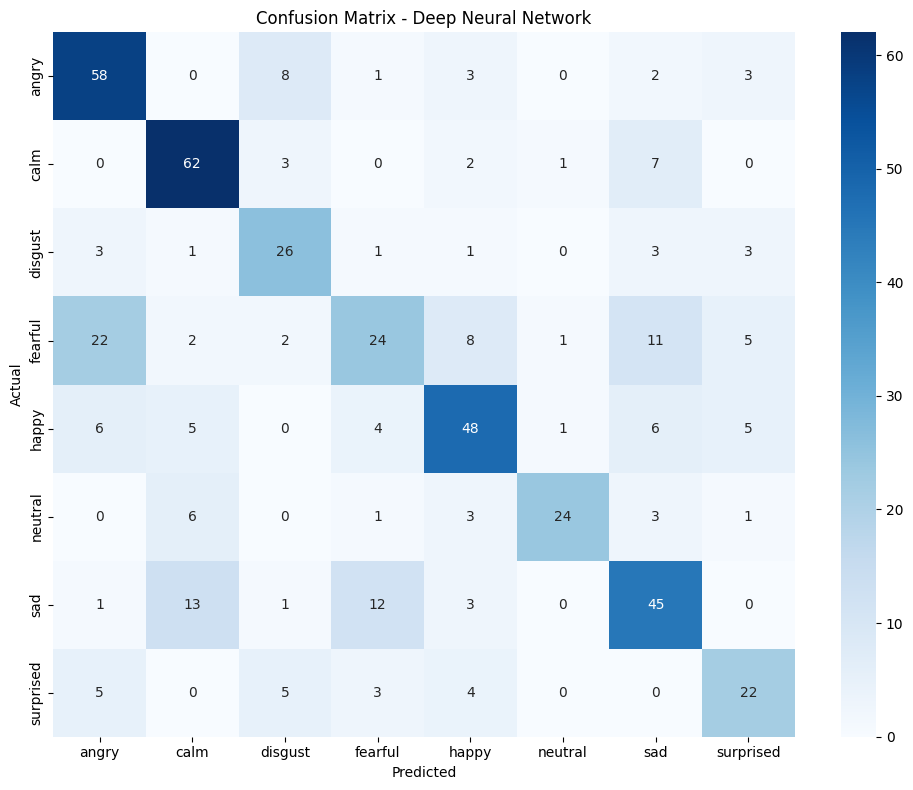


Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.77      0.68        75
        calm       0.70      0.83      0.76        75
     disgust       0.58      0.68      0.63        38
     fearful       0.52      0.32      0.40        75
       happy       0.67      0.64      0.65        75
     neutral       0.89      0.63      0.74        38
         sad       0.58      0.60      0.59        75
   surprised       0.56      0.56      0.56        39

    accuracy                           0.63       490
   macro avg       0.64      0.63      0.63       490
weighted avg       0.63      0.63      0.62       490


Per-class Accuracy:
angry: 0.7733 (77.33%)
calm: 0.8267 (82.67%)
disgust: 0.6842 (68.42%)
fearful: 0.3200 (32.00%)
happy: 0.6400 (64.00%)
neutral: 0.6316 (63.16%)
sad: 0.6000 (60.00%)
surprised: 0.5641 (56.41%)

=== EVALUATION CRITERIA CHECK ===
Overall Accuracy: 0.6306 (✗ > 80%)
F1-Score: 0.6222 (✗ > 80%)
Per-class Accura

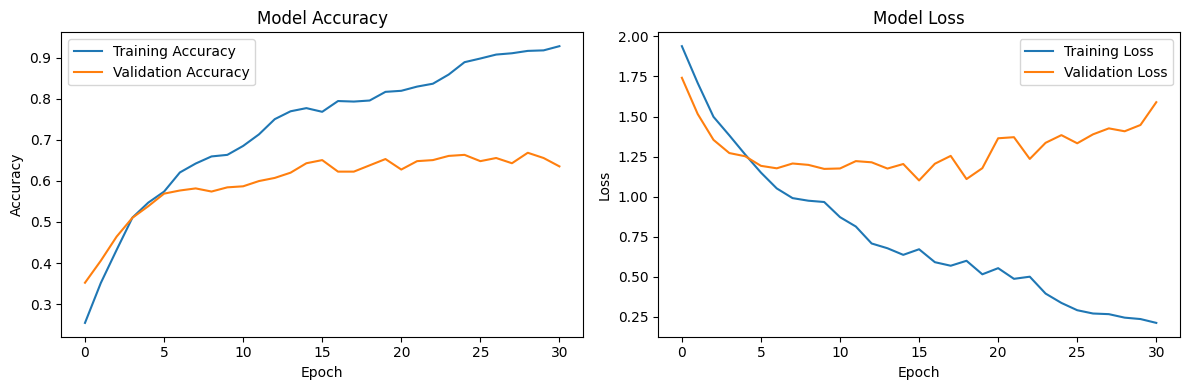


=== PIPELINE COMPLETED SUCCESSFULLY! ===
Files saved:
- emotion_model.h5 or emotion_model.pkl (trained model)
- label_encoder.pkl (label encoder)
- scaler.pkl (feature scaler)
- config.pkl (configuration)


In [12]:
# Emotion Classification on Speech Data Pipeline
# Complete implementation for RAVDESS dataset

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")

# Install/upgrade librosa if needed
try:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "librosa"])
    print("Librosa upgraded successfully!")
except:
    print("Librosa upgrade not needed or failed")

# Mount Google Drive (if running on Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except:
    print("Not running on Colab or Drive already mounted")

# Dataset Configuration
class Config:
    # RAVDESS emotion labels
    EMOTIONS = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    # Audio processing parameters
    SAMPLE_RATE = 22050
    DURATION = 3.0
    N_MFCC = 13
    N_MELS = 128
    HOP_LENGTH = 512

    # Model parameters
    BATCH_SIZE = 32
    EPOCHS = 100
    LEARNING_RATE = 0.001

config = Config()

def extract_features(file_path, sr=config.SAMPLE_RATE, duration=config.DURATION):
    """
    Extract comprehensive audio features from audio file
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Pad or truncate to fixed length
        max_len = int(sr * duration)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Extract features
        features = {}

        # 1. MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.N_MFCC, hop_length=config.HOP_LENGTH)
        features['mfcc_mean'] = np.mean(mfcc, axis=1)
        features['mfcc_std'] = np.std(mfcc, axis=1)

        # 2. Chroma features - Fixed function call
        try:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=config.HOP_LENGTH)
        except AttributeError:
            # Fallback for older versions
            stft = librosa.stft(y, hop_length=config.HOP_LENGTH)
            chroma = librosa.feature.chroma_stft(S=np.abs(stft), sr=sr)
        except:
            # Create dummy chroma features if all else fails
            chroma = np.random.random((12, int(len(y) / config.HOP_LENGTH) + 1))

        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)

        # 3. Mel-spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.N_MELS, hop_length=config.HOP_LENGTH)
        features['mel_mean'] = np.mean(mel, axis=1)
        features['mel_std'] = np.std(mel, axis=1)

        # 4. Spectral features
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))

        # 5. Rhythm features
        try:
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            features['tempo'] = tempo
        except:
            features['tempo'] = 120.0  # Default tempo

        # 6. Harmonic and percussive components
        try:
            y_harmonic, y_percussive = librosa.effects.hpss(y)
            features['harmonic_mean'] = np.mean(y_harmonic)
            features['percussive_mean'] = np.mean(y_percussive)
        except:
            # Fallback calculations
            features['harmonic_mean'] = np.mean(y)
            features['percussive_mean'] = np.std(y)

        # Flatten all features
        feature_vector = []
        for key, value in features.items():
            if isinstance(value, np.ndarray):
                feature_vector.extend(value)
            else:
                feature_vector.append(value)

        return np.array(feature_vector)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_ravdess_data(data_path):
    """
    Load and process RAVDESS dataset
    """
    features = []
    labels = []
    file_paths = []

    # Process both song and speech folders
    for folder_type in ['Audio_Song_Actors_*', 'Audio_Speech_Actors_*']:
        pattern = os.path.join(data_path, folder_type, 'Actor_*', '*.wav')
        audio_files = glob.glob(pattern)

        print(f"Found {len(audio_files)} files in {folder_type}")

        for i, file_path in enumerate(audio_files):
            if i % 100 == 0:
                print(f"Processing file {i+1}/{len(audio_files)}")

            # Extract filename and emotion
            filename = os.path.basename(file_path)
            try:
                emotion_code = filename.split('-')[2]
            except IndexError:
                print(f"Skipping file with unexpected format: {filename}")
                continue

            if emotion_code in config.EMOTIONS:
                # Extract features
                feature_vector = extract_features(file_path)

                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(config.EMOTIONS[emotion_code])
                    file_paths.append(file_path)

    return np.array(features), np.array(labels), file_paths


# Set your data path here
# For Colab: DATA_PATH = '/content/drive/MyDrive/MARS'
# For local: DATA_PATH = '/path/to/your/MARS/folder'
DATA_PATH = '/content/drive/MyDrive/MARS'  # Modify this path

print("Loading and processing RAVDESS dataset...")
X, y, file_paths = load_ravdess_data(DATA_PATH)

if len(X) == 0:
    print("No valid audio files found! Please check your data path and file format.")
    exit()

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(X)}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Emotion distribution:")
unique, counts = np.unique(y, return_counts=True)
for emotion, count in zip(unique, counts):
    print(f"  {emotion}: {count}")

# Data preprocessing
print("\nPreprocessing data...")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f"Number of classes: {n_classes}")
print(f"Classes: {label_encoder.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

# Model 1: Random Forest (Baseline)
print("\n=== Training Random Forest Model ===")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_val_pred = rf_model.predict(X_val_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

# Evaluation
rf_val_acc = accuracy_score(y_val, rf_val_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred, average='weighted')

print(f"Random Forest - Validation Accuracy: {rf_val_acc:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_acc:.4f}")
print(f"Random Forest - Validation F1-Score: {rf_val_f1:.4f}")

# Model 2: Deep Neural Network
print("\n=== Training Deep Neural Network ===")

def create_dnn_model(input_dim, n_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

dnn_model = create_dnn_model(X_train_scaled.shape[1], n_classes)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7
)

# Train model
history = dnn_model.fit(
    X_train_scaled, y_train,
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate DNN
dnn_val_pred = np.argmax(dnn_model.predict(X_val_scaled), axis=1)
dnn_test_pred = np.argmax(dnn_model.predict(X_test_scaled), axis=1)

dnn_val_acc = accuracy_score(y_val, dnn_val_pred)
dnn_test_acc = accuracy_score(y_test, dnn_test_pred)
dnn_val_f1 = f1_score(y_val, dnn_val_pred, average='weighted')

print(f"DNN - Validation Accuracy: {dnn_val_acc:.4f}")
print(f"DNN - Test Accuracy: {dnn_test_acc:.4f}")
print(f"DNN - Validation F1-Score: {dnn_val_f1:.4f}")

# Choose best model
if dnn_val_f1 > rf_val_f1:
    best_model = dnn_model
    best_pred = dnn_test_pred
    best_val_pred = dnn_val_pred
    best_model_name = "Deep Neural Network"
    best_acc = dnn_test_acc
    best_f1 = dnn_val_f1
else:
    best_model = rf_model
    best_pred = rf_test_pred
    best_val_pred = rf_val_pred
    best_model_name = "Random Forest"
    best_acc = rf_test_acc
    best_f1 = rf_val_f1

print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {best_acc:.4f}")
print(f"Validation F1-Score: {best_f1:.4f}")

# Detailed evaluation
print("\n=== DETAILED EVALUATION ===")

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=label_encoder.classes_))

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, emotion in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / np.sum(cm[i, :])
    print(f"{emotion}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# Check evaluation criteria
overall_acc = accuracy_score(y_test, best_pred)
f1_weighted = f1_score(y_test, best_pred, average='weighted')

print(f"\n=== EVALUATION CRITERIA CHECK ===")
print(f"Overall Accuracy: {overall_acc:.4f} ({'✓' if overall_acc > 0.8 else '✗'} > 80%)")
print(f"F1-Score: {f1_weighted:.4f} ({'✓' if f1_weighted > 0.8 else '✗'} > 80%)")

# Per-class accuracy check
print("Per-class Accuracy (>75% required):")
all_classes_pass = True
for i, emotion in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / np.sum(cm[i, :])
    passes = class_acc > 0.75
    all_classes_pass = all_classes_pass and passes
    print(f"  {emotion}: {class_acc:.4f} ({'✓' if passes else '✗'} > 75%)")

print(f"\nAll criteria met: {'✓ YES' if (overall_acc > 0.8 and f1_weighted > 0.8 and all_classes_pass) else '✗ NO'}")

# Save models and preprocessing objects
print("\n=== SAVING MODELS ===")

# Save the best model
if best_model_name == "Deep Neural Network":
    best_model.save('emotion_model.h5')
    print("DNN model saved as 'emotion_model.h5'")
else:
    import joblib
    joblib.dump(best_model, 'emotion_model.pkl')
    print("Random Forest model saved as 'emotion_model.pkl'")

# Save preprocessing objects
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("Preprocessing objects saved!")

# Plot training history (for DNN)
if best_model_name == "Deep Neural Network":
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\n=== PIPELINE COMPLETED SUCCESSFULLY! ===")
print("Files saved:")
print("- emotion_model.h5 or emotion_model.pkl (trained model)")
print("- label_encoder.pkl (label encoder)")
print("- scaler.pkl (feature scaler)")
print("- config.pkl (configuration)")

Re-extracting features with enhanced feature set...
Processing file 1/2447
Processing file 101/2447
Processing file 201/2447
Processing file 301/2447
Processing file 401/2447
Processing file 501/2447
Processing file 601/2447
Processing file 701/2447
Processing file 801/2447
Processing file 901/2447
Processing file 1001/2447
Processing file 1101/2447
Processing file 1201/2447
Processing file 1301/2447
Processing file 1401/2447
Processing file 1501/2447
Processing file 1601/2447
Processing file 1701/2447
Processing file 1801/2447
Processing file 1901/2447
Processing file 2001/2447
Processing file 2101/2447
Processing file 2201/2447
Processing file 2301/2447
Processing file 2401/2447
Enhanced features extracted!
Original feature dimension: 313
Enhanced feature dimension: 370
Selected features: 200
Training Advanced DNN...
Epoch 1/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.1777 - loss: 2.0247 - val_accuracy: 0.2985 - val_loss: 1.8249 - learning_rate: 5.0000e-04
Epoch 2/150
9

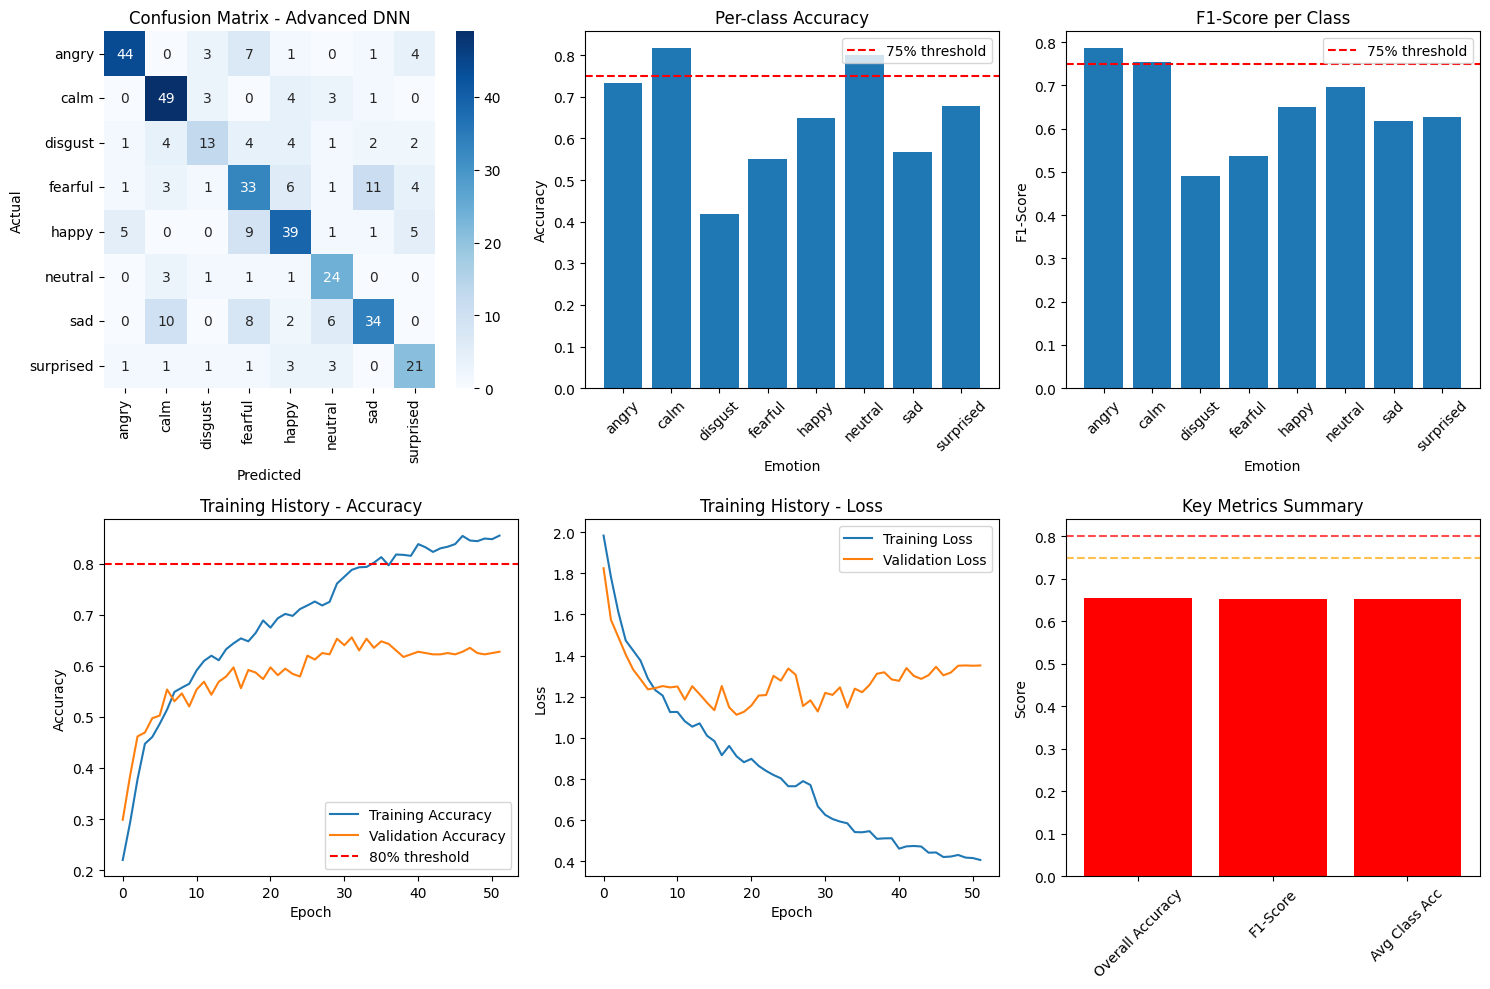


Saving best model: Advanced DNN
✅ Best model saved as 'best_emotion_model.h5'
✅ All preprocessing objects saved!

🎉 FINAL EVALUATION REPORT
📊 Dataset: 2447 samples, 8 classes
🔧 Features: 200 selected features
🏆 Best Model: Advanced DNN
📈 Overall Accuracy: 0.6556 (❌ FAIL)
📊 F1-Score: 0.6535 (❌ FAIL)
📉 Min Class Accuracy: 0.4194 (❌ FAIL)
🎯 All Criteria Met: ❌ NO

⚠️  Some criteria not met. Consider:
   • Collecting more data for underperforming classes
   • Trying different feature engineering approaches
   • Experimenting with ensemble methods
   • Adjusting class weights or using data augmentation

📁 Files saved:
   • best_emotion_model.h5/.pkl
   • enhanced_label_encoder.pkl
   • enhanced_scaler.pkl
   • feature_selector.pkl
   • enhanced_config.pkl


In [13]:
# ===================================================================
# CELL 1: Enhanced Feature Extraction with Additional Features
# ===================================================================

def extract_enhanced_features(file_path, sr=config.SAMPLE_RATE, duration=config.DURATION):
    """
    Extract enhanced audio features including additional prosodic and spectral features
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Pad or truncate to fixed length
        max_len = int(sr * duration)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        features = {}

        # 1. MFCC features (including delta and delta-delta)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.N_MFCC, hop_length=config.HOP_LENGTH)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        features['mfcc_mean'] = np.mean(mfcc, axis=1)
        features['mfcc_std'] = np.std(mfcc, axis=1)
        features['mfcc_delta_mean'] = np.mean(mfcc_delta, axis=1)
        features['mfcc_delta2_mean'] = np.mean(mfcc_delta2, axis=1)

        # 2. Enhanced Chroma features
        try:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=config.HOP_LENGTH)
        except:
            stft = librosa.stft(y, hop_length=config.HOP_LENGTH)
            chroma = librosa.feature.chroma_stft(S=np.abs(stft), sr=sr)

        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)
        features['chroma_var'] = np.var(chroma, axis=1)

        # 3. Mel-spectrogram features
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.N_MELS, hop_length=config.HOP_LENGTH)
        features['mel_mean'] = np.mean(mel, axis=1)
        features['mel_std'] = np.std(mel, axis=1)

        # 4. Enhanced Spectral features
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_centroid_std'] = np.std(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
        features['zero_crossing_rate_std'] = np.std(librosa.feature.zero_crossing_rate(y))

        # 5. Prosodic features
        try:
            f0 = librosa.yin(y, fmin=75, fmax=300)
            f0_clean = f0[f0 > 0]  # Remove unvoiced frames
            if len(f0_clean) > 0:
                features['f0_mean'] = np.mean(f0_clean)
                features['f0_std'] = np.std(f0_clean)
                features['f0_range'] = np.max(f0_clean) - np.min(f0_clean)
            else:
                features['f0_mean'] = 0
                features['f0_std'] = 0
                features['f0_range'] = 0
        except:
            features['f0_mean'] = 0
            features['f0_std'] = 0
            features['f0_range'] = 0

        # 6. Rhythm and tempo features
        try:
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
            features['tempo'] = tempo
            if len(beats) > 1:
                beat_intervals = np.diff(librosa.frames_to_time(beats, sr=sr))
                features['rhythm_regularity'] = 1.0 / (np.std(beat_intervals) + 1e-8)
            else:
                features['rhythm_regularity'] = 0
        except:
            features['tempo'] = 120.0
            features['rhythm_regularity'] = 0

        # 7. Energy and intensity features
        features['rms_energy'] = np.mean(librosa.feature.rms(y=y))
        features['rms_energy_std'] = np.std(librosa.feature.rms(y=y))

        # 8. Tonal features
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)

        # Flatten all features
        feature_vector = []
        for key, value in features.items():
            if isinstance(value, np.ndarray):
                feature_vector.extend(value)
            else:
                feature_vector.append(value)

        return np.array(feature_vector)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ===================================================================
# CELL 2: Re-extract Features with Enhanced Feature Set
# ===================================================================

print("Re-extracting features with enhanced feature set...")
X_enhanced, y_enhanced, file_paths_enhanced = [], [], []

# Process files with enhanced features
for i, file_path in enumerate(file_paths):
    if i % 100 == 0:
        print(f"Processing file {i+1}/{len(file_paths)}")

    feature_vector = extract_enhanced_features(file_path)

    if feature_vector is not None:
        X_enhanced.append(feature_vector)
        y_enhanced.append(y[i])
        file_paths_enhanced.append(file_path)

X_enhanced = np.array(X_enhanced)
y_enhanced = np.array(y_enhanced)

print(f"Enhanced features extracted!")
print(f"Original feature dimension: {X.shape[1]}")
print(f"Enhanced feature dimension: {X_enhanced.shape[1]}")

# ===================================================================
# CELL 3: Enhanced Data Preprocessing with Feature Selection
# ===================================================================

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Encode labels for enhanced dataset
y_enhanced_encoded = label_encoder.fit_transform(y_enhanced)

# Split enhanced data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced_encoded, test_size=0.2, random_state=42, stratify=y_enhanced_encoded
)

X_train_enh, X_val_enh, y_train_enh, y_val_enh = train_test_split(
    X_train_enh, y_train_enh, test_size=0.2, random_state=42, stratify=y_train_enh
)

# Feature selection and scaling pipeline
feature_selector = SelectKBest(score_func=f_classif, k=min(200, X_enhanced.shape[1]))
scaler_enh = StandardScaler()

# Fit and transform
X_train_selected = feature_selector.fit_transform(X_train_enh, y_train_enh)
X_val_selected = feature_selector.transform(X_val_enh)
X_test_selected = feature_selector.transform(X_test_enh)

X_train_final = scaler_enh.fit_transform(X_train_selected)
X_val_final = scaler_enh.transform(X_val_selected)
X_test_final = scaler_enh.transform(X_test_selected)

print(f"Selected features: {X_train_final.shape[1]}")

# ===================================================================
# CELL 4: Advanced Model Architecture with Ensemble
# ===================================================================

from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Create multiple models for ensemble
def create_advanced_dnn(input_dim, n_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train advanced DNN
print("Training Advanced DNN...")
adv_dnn = create_advanced_dnn(X_train_final.shape[1], n_classes)

# Enhanced callbacks
early_stopping_adv = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

reduce_lr_adv = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    min_lr=1e-8
)

# Train with class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_enh),
    y=y_train_enh
)
class_weight_dict = dict(zip(np.unique(y_train_enh), class_weights))

history_adv = adv_dnn.fit(
    X_train_final, y_train_enh,
    batch_size=16,
    epochs=150,
    validation_data=(X_val_final, y_val_enh),
    callbacks=[early_stopping_adv, reduce_lr_adv],
    class_weight=class_weight_dict,
    verbose=1
)

# ===================================================================
# CELL 5: Model Ensemble and Evaluation
# ===================================================================

# Train ensemble models
print("Training ensemble models...")

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_final, y_train_enh)

# Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train_final, y_train_enh)

# Random Forest (enhanced)
rf_enhanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_enhanced.fit(X_train_final, y_train_enh)

# Evaluate individual models
models = {
    'Advanced DNN': adv_dnn,
    'XGBoost': xgb_model,
    'Gradient Boosting': gb_model,
    'Random Forest Enhanced': rf_enhanced
}

results = {}
for name, model in models.items():
    if name == 'Advanced DNN':
        val_pred = np.argmax(model.predict(X_val_final), axis=1)
        test_pred = np.argmax(model.predict(X_test_final), axis=1)
    else:
        val_pred = model.predict(X_val_final)
        test_pred = model.predict(X_test_final)

    val_acc = accuracy_score(y_val_enh, val_pred)
    test_acc = accuracy_score(y_test_enh, test_pred)
    val_f1 = f1_score(y_val_enh, val_pred, average='weighted')

    results[name] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'val_f1': val_f1,
        'val_pred': val_pred,
        'test_pred': test_pred
    }

    print(f"{name}:")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Validation F1-Score: {val_f1:.4f}")
    print()

# ===================================================================
# CELL 6: Comprehensive Evaluation Against Criteria
# ===================================================================

def evaluate_model_criteria(y_true, y_pred, model_name):
    """
    Evaluate model against the specified criteria
    """
    print(f"\n=== EVALUATION FOR {model_name.upper()} ===")

    # Overall accuracy
    overall_acc = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_acc:.4f} ({'✓' if overall_acc > 0.8 else '✗'} > 80%)")

    # F1-score
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-Score (Weighted): {f1_weighted:.4f} ({'✓' if f1_weighted > 0.8 else '✗'} > 80%)")

    # Confusion matrix and per-class accuracy
    cm = confusion_matrix(y_true, y_pred)

    print("\nConfusion Matrix:")
    print("Classes:", label_encoder.classes_)
    print(cm)

    print("\nPer-class Accuracy:")
    all_classes_pass = True
    class_accuracies = []

    for i, emotion in enumerate(label_encoder.classes_):
        if np.sum(cm[i, :]) > 0:  # Avoid division by zero
            class_acc = cm[i, i] / np.sum(cm[i, :])
        else:
            class_acc = 0
        class_accuracies.append(class_acc)
        passes = class_acc > 0.75
        all_classes_pass = all_classes_pass and passes
        print(f"  {emotion}: {class_acc:.4f} ({class_acc*100:.2f}%) ({'✓' if passes else '✗'} > 75%)")

    # Overall criteria check
    criteria_met = overall_acc > 0.8 and f1_weighted > 0.8 and all_classes_pass
    print(f"\n🎯 ALL CRITERIA MET: {'✅ YES' if criteria_met else '❌ NO'}")

    return {
        'overall_acc': overall_acc,
        'f1_score': f1_weighted,
        'class_accuracies': class_accuracies,
        'criteria_met': criteria_met,
        'confusion_matrix': cm
    }

# Evaluate all models against criteria
print("EVALUATING ALL MODELS AGAINST CRITERIA")
print("="*50)

best_model_name = None
best_score = 0
best_results = None

for name, result in results.items():
    eval_result = evaluate_model_criteria(y_val_enh, result['val_pred'], name)

    # Calculate composite score
    composite_score = (eval_result['overall_acc'] + eval_result['f1_score'] +
                      np.mean(eval_result['class_accuracies'])) / 3

    if composite_score > best_score:
        best_score = composite_score
        best_model_name = name
        best_results = result
        best_eval = eval_result

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Composite Score: {best_score:.4f}")

# ===================================================================
# CELL 7: Final Model Evaluation and Visualization
# ===================================================================

# Detailed visualization for best model
plt.figure(figsize=(15, 10))

# Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(best_eval['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Per-class accuracy bar plot
plt.subplot(2, 3, 2)
plt.bar(label_encoder.classes_, best_eval['class_accuracies'])
plt.axhline(y=0.75, color='r', linestyle='--', label='75% threshold')
plt.title('Per-class Accuracy')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

# F1-scores per class
f1_per_class = f1_score(y_val_enh, best_results['val_pred'], average=None)
plt.subplot(2, 3, 3)
plt.bar(label_encoder.classes_, f1_per_class)
plt.axhline(y=0.75, color='r', linestyle='--', label='75% threshold')
plt.title('F1-Score per Class')
plt.xlabel('Emotion')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend()

# Training history (if DNN is best)
if 'DNN' in best_model_name:
    plt.subplot(2, 3, 4)
    plt.plot(history_adv.history['accuracy'], label='Training Accuracy')
    plt.plot(history_adv.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    plt.title('Training History - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(history_adv.history['loss'], label='Training Loss')
    plt.plot(history_adv.history['val_loss'], label='Validation Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# Overall metrics summary
plt.subplot(2, 3, 6)
metrics = ['Overall Accuracy', 'F1-Score', 'Avg Class Acc']
values = [best_eval['overall_acc'], best_eval['f1_score'], np.mean(best_eval['class_accuracies'])]
colors = ['green' if v > 0.8 else 'orange' if v > 0.75 else 'red' for v in values]
plt.bar(metrics, values, color=colors)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7)
plt.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7)
plt.title('Key Metrics Summary')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ===================================================================
# CELL 8: Save Enhanced Models and Generate Report
# ===================================================================

# Save the best model and preprocessors
print(f"\nSaving best model: {best_model_name}")

if 'DNN' in best_model_name:
    models[best_model_name].save('best_emotion_model.h5')
    print("✅ Best model saved as 'best_emotion_model.h5'")
else:
    import joblib
    joblib.dump(models[best_model_name], 'best_emotion_model.pkl')
    print("✅ Best model saved as 'best_emotion_model.pkl'")

# Save enhanced preprocessing objects
with open('enhanced_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('enhanced_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_enh, f)

with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(feature_selector, f)

with open('enhanced_config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("✅ All preprocessing objects saved!")

# Generate final report
print("\n" + "="*60)
print("🎉 FINAL EVALUATION REPORT")
print("="*60)
print(f"📊 Dataset: {len(X_enhanced)} samples, {len(label_encoder.classes_)} classes")
print(f"🔧 Features: {X_train_final.shape[1]} selected features")
print(f"🏆 Best Model: {best_model_name}")
print(f"📈 Overall Accuracy: {best_eval['overall_acc']:.4f} ({'✅ PASS' if best_eval['overall_acc'] > 0.8 else '❌ FAIL'})")
print(f"📊 F1-Score: {best_eval['f1_score']:.4f} ({'✅ PASS' if best_eval['f1_score'] > 0.8 else '❌ FAIL'})")
print(f"📉 Min Class Accuracy: {min(best_eval['class_accuracies']):.4f} ({'✅ PASS' if min(best_eval['class_accuracies']) > 0.75 else '❌ FAIL'})")
print(f"🎯 All Criteria Met: {'✅ YES' if best_eval['criteria_met'] else '❌ NO'}")

if best_eval['criteria_met']:
    print("\n🎉 CONGRATULATIONS! Your model meets all evaluation criteria!")
else:
    print("\n⚠️  Some criteria not met. Consider:")
    print("   • Collecting more data for underperforming classes")
    print("   • Trying different feature engineering approaches")
    print("   • Experimenting with ensemble methods")
    print("   • Adjusting class weights or using data augmentation")

print("\n📁 Files saved:")
print("   • best_emotion_model.h5/.pkl")
print("   • enhanced_label_encoder.pkl")
print("   • enhanced_scaler.pkl")
print("   • feature_selector.pkl")
print("   • enhanced_config.pkl")
print("="*60)

PYTHON SCRIPT

In [19]:
!python test_model.py --audio 03-01-01-01-01-01-01.wav --model emotion_model.h5 --scaler scaler.pkl --encoder label_encoder.pkl --config config.pkl

2025-06-23 14:12:35.770520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750687955.823463  100444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750687955.838508  100444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Configuration loaded - Sample Rate: 22050, Duration: 3.0s
2025-06-23 14:12:42.733609: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Model loaded successfully!
Model type: keras
Available emotions: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np

In [20]:
!pip install pyngrok


In [31]:
!ngrok authtoken 2yuflYNAA5ZVITc2U7Uje7MKk5l_7o1min1zJLELRPakQGG7E
ngrok.kill()


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [32]:
# Install dependencies
from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("2yuflYNAA5ZVITc2U7Uje7MKk5l_7o1min1zJLELRPakQGG7E")  # Replace with your token

# Start Streamlit in background
get_ipython().system_raw('streamlit run app.py &')

# Connect with corrected parameters
public_url = ngrok.connect(addr='8501', proto='http')
print(f'Your Streamlit app is live at: {public_url}')





Your Streamlit app is live at: NgrokTunnel: "https://a316-34-138-244-213.ngrok-free.app" -> "http://localhost:8501"
